# Plots for the 2MDM analysis

In [23]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from auxPlots import columnsDict, colorDict, defaultPars
import itertools

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
plt.rcParams.update(defaultPars) #Figure resolution

#### Get data in pcl format and print all columns names

In [24]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodels_results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['filename', 'mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'ExptRes.result0.maxcond', 'ExptRes.result0.theory prediction (fb)', 'ExptRes.result0.upper limit (fb)', 'ExptRes.result0.expected upper limit (fb)', 'ExptRes.result0.TxNames', 'ExptRes.result0.M

#### Set r = 0 for points with no results 

In [25]:
#Set points without results with r == 0
dataDF.fillna(value={c : 0 for c in dataDF.columns if c.endswith('.r')}, inplace=True)
#Sort points according to r value:
dataDF = dataDF.sort_values(by=['ExptRes.result0.r'],ascending=False)

#### Define exclusions

In [26]:
#Add simple flag for excluded points:
dataDF['excludedLHC'] = dataDF['ExptRes.result0.r'] > 1.0

### Get points excluded:

In [27]:
excluded = dataDF[dataDF['excludedLHC'] == True]

allowed = dataDF[(dataDF['excludedLHC'] == False)]


print('Total number of points = %i' %len(dataDF))
print('Total excluded (LHC) = %i'%(len(excluded)))
print('Total allowed = %i\n'%(len(allowed)))

# print('Total excluded (r > %1.2f) = %i'%(rscale,len(excludedSC)))
# print('Total allowed (r > %1.2f) = %i'%(rscale,len(allowedSC)))


Total number of points = 21000
Total excluded (LHC) = 9780
Total allowed = 11220



#### Filter couplings

In [28]:
dataDF = dataDF[((dataDF['gchi'] == 0.01) & (dataDF['gq'] == 0.1) & (dataDF['sina'] == 0.25)) 
                | ((dataDF['gchi'] == 0.01) & (dataDF['gq'] == 0.15) & (dataDF['sina'] == 0.25))]
dataDF.reset_index(inplace=True)

### Split dataframe by analysis ID

In [29]:
# Get ExptRes columns and group according to ExptRes attribute
expResCols = np.array(sorted([c for c in dataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
expCols = itertools.groupby(expResCols, key = lambda c: c.split('.')[-1])

# Get all analyses
idCols = np.array([c for c in dataDF.columns if 'AnalysisID' in c])
analysis = sorted(dataDF[idCols].stack().drop_duplicates().tolist())
# Get all Txnames
txCols = np.array([c for c in dataDF.columns if 'TxNames' in c and not 'weights' in c])
txnames = sorted(dataDF[txCols].stack().drop_duplicates().tolist())

# Merge all common ExptRes columns into single columns containing a list of results
newDataDF = dataDF.copy()
for key,group in expCols:
    g = list(group)
    newCol = f'ExptRes.result.{key}'
    newDataDF[newCol] = newDataDF[g].values.tolist()
    newDataDF.drop(columns=g,inplace=True)


# Now explode each list of values into distinct rows
expResColsNew = np.array(sorted([c for c in newDataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1]))
newDataDFexp = newDataDF.explode(list(expResColsNew))

# Finally group using analsysis IDs
anaGroups = newDataDFexp.groupby(by=['ExptRes.result.AnalysisID'])

In [30]:
anaDict = {ana[0] : anadf for ana,anadf in anaGroups}

### Add r_expected for CMS-EXO-19-012 (assuming the curve for NWA from Fig.6a)

In [31]:
# Values from Fig.6a (HEPData-ins1764471-v1-Cross-section_limits_for_a_quark-quark_type_dijet_resonance.csv)
cmsUL = np.array([(1800.0, 0.078516, 0.091395), (1900.0, 0.066992, 0.092696), (2000.0, 0.053711, 0.077353), (2100.0, 0.041602, 0.056841), (2200.0, 0.032715, 0.027284), (2300.0, 0.026855, 0.012014), (2400.0, 0.022754, 0.014161), (2500.0, 0.019824, 0.01895), (2600.0, 0.017334, 0.025214), (2700.0, 0.015283, 0.025508), (2800.0, 0.013428, 0.023552), (2900.0, 0.011768, 0.019059), (3000.0, 0.011316, 0.021692), (3100.0, 0.0098511, 0.016443), (3200.0, 0.0086792, 0.0094887), (3300.0, 0.0077271, 0.0071471), (3400.0, 0.0069031, 0.0066802), (3500.0, 0.0062439, 0.0068275), (3600.0, 0.0056396, 0.0077444), (3700.0, 0.0050903, 0.0084967), (3800.0, 0.0046143, 0.0082924), (3900.0, 0.0041931, 0.0078739), (4000.0, 0.0038086, 0.0073294), (4100.0, 0.0034607, 0.0051463), (4200.0, 0.0031403, 0.0025459), (4300.0, 0.0028473, 0.0016843), (4400.0, 0.0025726, 0.0018824), (4500.0, 0.0023315, 0.0025224), (4600.0, 0.0021057, 0.0030706), (4700.0, 0.0019135, 0.003087), (4800.0, 0.0017212, 0.0030344), (4900.0, 0.0015518, 0.0028889), (5000.0, 0.0013962, 0.0026911), (5100.0, 0.001268, 0.0022789), (5200.0, 0.0011581, 0.0015103), (5300.0, 0.0010529, 0.00099362), (5400.0, 0.00095673, 0.00074243), (5500.0, 0.00086517, 0.00060014), (5600.0, 0.00078278, 0.0005253), (5700.0, 0.00070953, 0.00049233), (5800.0, 0.00064545, 0.00046878), (5900.0, 0.00058594, 0.00044194), (6000.0, 0.00053558, 0.00041674), (6100.0, 0.00048981, 0.00039258), (6200.0, 0.00044403, 0.00036614), (6300.0, 0.00040741, 0.00033627), (6400.0, 0.00037079, 0.00029921), (6500.0, 0.00034332, 0.00026126), (6600.0, 0.00031586, 0.00022749), (6700.0, 0.00028839, 0.000196), (6800.0, 0.00026093, 0.00017398), (6900.0, 0.00024261, 0.00017428), (7000.0, 0.00021515, 0.00019238), (7100.0, 0.00019684, 0.00020811), (7200.0, 0.00017853, 0.00021186), (7300.0, 0.00016022, 0.0002126), (7400.0, 0.00014191, 0.00020838), (7500.0, 0.0001236, 0.0001982), (7600.0, 0.00011444, 0.00019094), (7700.0, 9.613e-05, 0.00017817), (7800.0, 8.6975e-05, 0.00015347), (7900.0, 7.782e-05, 0.00013324), (8000.0, 7.782e-05, 0.00012626), (8100.0, 6.8665e-05, 0.00012367), (8200.0, 6.8665e-05, 0.00011621), (8300.0, 6.4087e-05, 0.00011012), (8400.0, 5.7983e-05, 0.00010601), (8500.0, 5.9509e-05, 9.8669e-05), (8600.0, 5.9509e-05, 9.1325e-05), (8700.0, 5.9509e-05, 9.169e-05)],dtype=[('mZp', '<f4'), ('expUL', '<f4'), ('obsUL', '<f4')])
# Interpolating function:
ratioF = interp1d(cmsUL['mZp'],cmsUL['obsUL']/cmsUL['expUL'])
# plt.plot(cmsUL['mZp'],cmsUL['expUL'],label='Expected',linestyle='dashed')
# plt.plot(cmsUL['mZp'],cmsUL['obsUL'],label='Expected',linestyle='solid')
# plt.yscale('log')
# plt.legend()
# plt.show()
ratio = np.array([ratioF(m) for m in anaDict['CMS-EXO-19-012']['mZp']])
anaDict['CMS-EXO-19-012']['ExptRes.result.r_expected'] = anaDict['CMS-EXO-19-012']['ExptRes.result.r'].to_numpy()*ratio

# Plot Results for Resonance Searches

In [32]:
allAnas = ['ATLAS-EXOT-2019-03', 'ATLAS-EXOT-2013-11', 'CMS-EXO-19-012', 
           'ATLAS-EXOT-2018-48', 'CMS-EXO-12-059', 'CMS-EXO-20-008', 
           'CMS-EXO-16-057']
anaDictS = {ana : anaDict[ana] for ana in allAnas if ana in anaDict}

#### Create legend for plots for excluded points

In [33]:
legend = [mpatches.Patch(color=color, label=ana) for ana,color in colorDict.items()]

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

### Separate between dijet and heavy flavors

In [34]:
dijAnas = ['ATLAS-EXOT-2019-03', 'CMS-EXO-19-012', 'CMS-EXO-12-059', 'ATLAS-EXOT-2013-11']
otherAnas = ['ATLAS-EXOT-2018-48', 'CMS-EXO-20-008', 'CMS-EXO-16-057']

In [35]:
# Figure parameters
xlim = (-150, 3000)
ylim = (0, 4.0)


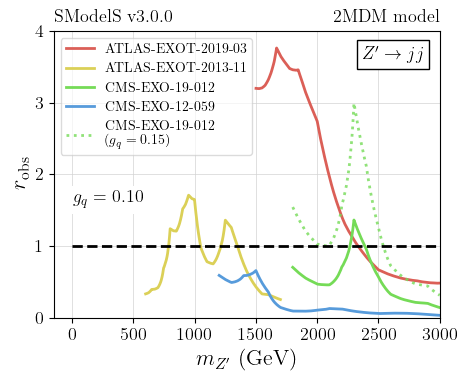

In [36]:
gq = 0.10
gchi = 0.01

for ana,anadf in anaDictS.items():
    if ana not in dijAnas:
        continue
    data = anadf[(anadf['gchi']==gchi) & (anadf['gq']==gq)].sort_values(['mZp'])   
    if len(data) == 0: continue
    x = data['mZp']
    y = data['ExptRes.result.r']
    label = ana
    pl = plt.plot(x, y, '-', label=label, c=colorDict[label])
    
gq_2 = 0.15
gchi_2 = 0.01
for ana,anadf in anaDictS.items():
    if ana not in dijAnas:
        continue
    data = anadf[(anadf['gchi']==gchi_2) & (anadf['gq']==gq_2)].sort_values(['mZp'])   
    if len(data) == 0: continue
    x = data['mZp']
    y = data['ExptRes.result.r']
    label = ana
    pl2 = plt.plot(x, y, linestyle='dotted', label=label+'\n'+r' ($g_{q} = %1.2f$)' %(gq_2), c=colorDict[label], alpha=0.8)

    

plt.hlines(1, 0, 3000, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$r_{\rm obs}$')
plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.text(0.05, 0.4,r'$g_{q} = %1.2f$' %(gq),
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)
plt.legend(loc='upper left', framealpha=0.7)

plt.text(0.8,0.9,r'$Z^\prime \to jj$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_resonance_dijet.png')
plt.show()


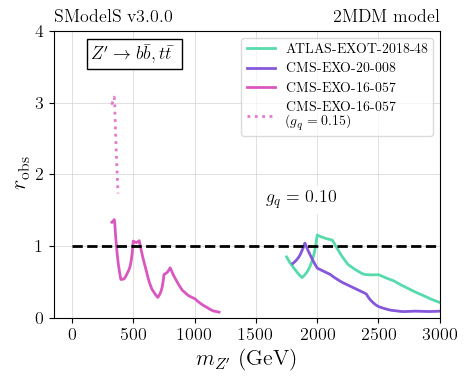

In [37]:
gq = 0.10
gchi = 0.01

for ana,anadf in anaDictS.items():
    if ana not in otherAnas:
        continue
    data = anadf[(anadf['gchi']==gchi) & (anadf['gq']==gq)].sort_values(['mZp'])   
    if len(data) == 0: continue
    x = data['mZp']
    y = data['ExptRes.result.r']
    label = ana
    pl = plt.plot(x, y, '-', label=label, c=colorDict[label])
    
gq_2 = 0.15
gchi_2 = 0.01
for ana,anadf in anaDictS.items():
    if ana not in otherAnas:
        continue
    data = anadf[(anadf['gchi']==gchi_2) & (anadf['gq']==gq_2)].sort_values(['mZp'])   
    if len(data) == 0: continue
    x = data['mZp']
    y = data['ExptRes.result.r']
    label = ana
    pl2 = plt.plot(x, y,  linestyle='dotted', label=label+'\n'+r' ($g_{q} = %1.2f$)' %(gq_2), c=colorDict[label], alpha=0.8)

    

plt.hlines(1, 0, 3000, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$r_{\rm obs}$')

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(*xlim)
plt.ylim(*ylim)


plt.text(0.55, 0.4,r'$g_{q} = %1.2f$' %(gq),
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)
plt.legend(loc='upper right', framealpha=0.7)

plt.text(0.1,0.9,r'$Z^\prime \to b\bar{b},t\bar{t}$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_resonance_heavyF.png')
plt.show()


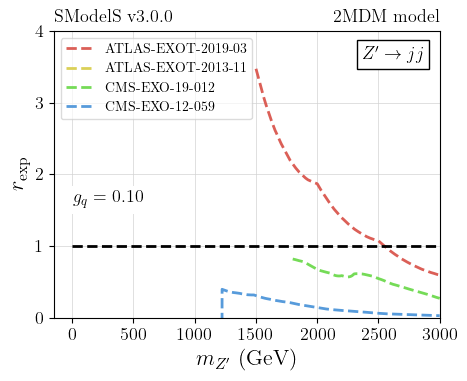

In [38]:
gq = 0.10
gchi = 0.01

for ana,anadf in anaDictS.items():
    if ana not in dijAnas:
        continue
    data = anadf[(anadf['gchi']==gchi) & (anadf['gq']==gq)].sort_values(['mZp'])   
    if len(data) == 0: continue
    x = data['mZp']
    y = data['ExptRes.result.r_expected']
    label = ana
    pl = plt.plot(x, y, linestyle='dashed', label=label, c=colorDict[label])
    

    

plt.hlines(1, 0, 3000, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$r_{\rm exp}$')
plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(*xlim)
plt.ylim(*ylim)

plt.text(0.05, 0.4,r'$g_{q} = %1.2f$' %(gq),
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)
plt.legend(loc='upper left', framealpha=0.7)

plt.text(0.8,0.9,r'$Z^\prime \to jj$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_resonance_dijet_exp.png')
plt.show()


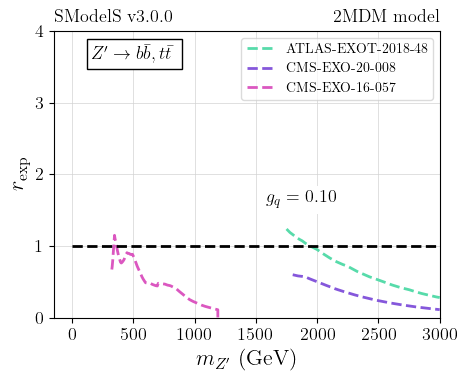

In [39]:
gq = 0.10
gchi = 0.01

for ana,anadf in anaDictS.items():
    if ana not in otherAnas:
        continue
    data = anadf[(anadf['gchi']==gchi) & (anadf['gq']==gq)].sort_values(['mZp'])   
    if len(data) == 0: continue
    x = data['mZp']
    y = data['ExptRes.result.r_expected']
    label = ana
    pl = plt.plot(x, y, linestyle='dashed', label=label, c=colorDict[label])
    

    

plt.hlines(1, 0, 3000, linestyles='--', color='black')
plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)')
plt.ylabel(r'$r_{\rm exp}$')

plt.title(r'SModelS v3.0.0', loc='left')
plt.title(r'2MDM model', loc='right')

plt.xlim(*xlim)
plt.ylim(*ylim)


plt.text(0.55, 0.4,r'$g_{q} = %1.2f$' %(gq),
         bbox=dict(facecolor='white', edgecolor='none'),transform = plt.gca().transAxes)
plt.legend(loc='upper right', framealpha=0.7)

plt.text(0.1,0.9,r'$Z^\prime \to b\bar{b},t\bar{t}$',
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)

plt.tight_layout()
plt.savefig('./figures/exclusions_2mdm_resonance_heavyF_exp.png')
plt.show()
